# 집값예측
- [캐글링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/)
## 목표
- 캐글 경진대회 참여
- 앙상블 기법 이해
- 하이퍼 파라미터 튜닝 => Grid Search, Random Search 기법 이해
- Grid Search를 활용해서 직접 하이퍼 파라미터 튜닝을 실험

# 코드

## 라이브러리 import

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


import os
from os.path import join
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns

In [2]:
font = {'size' : 15}
matplotlib.rc('font', **font)

## 데이터 준비

In [3]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'

In [4]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

### 상관계수 확인

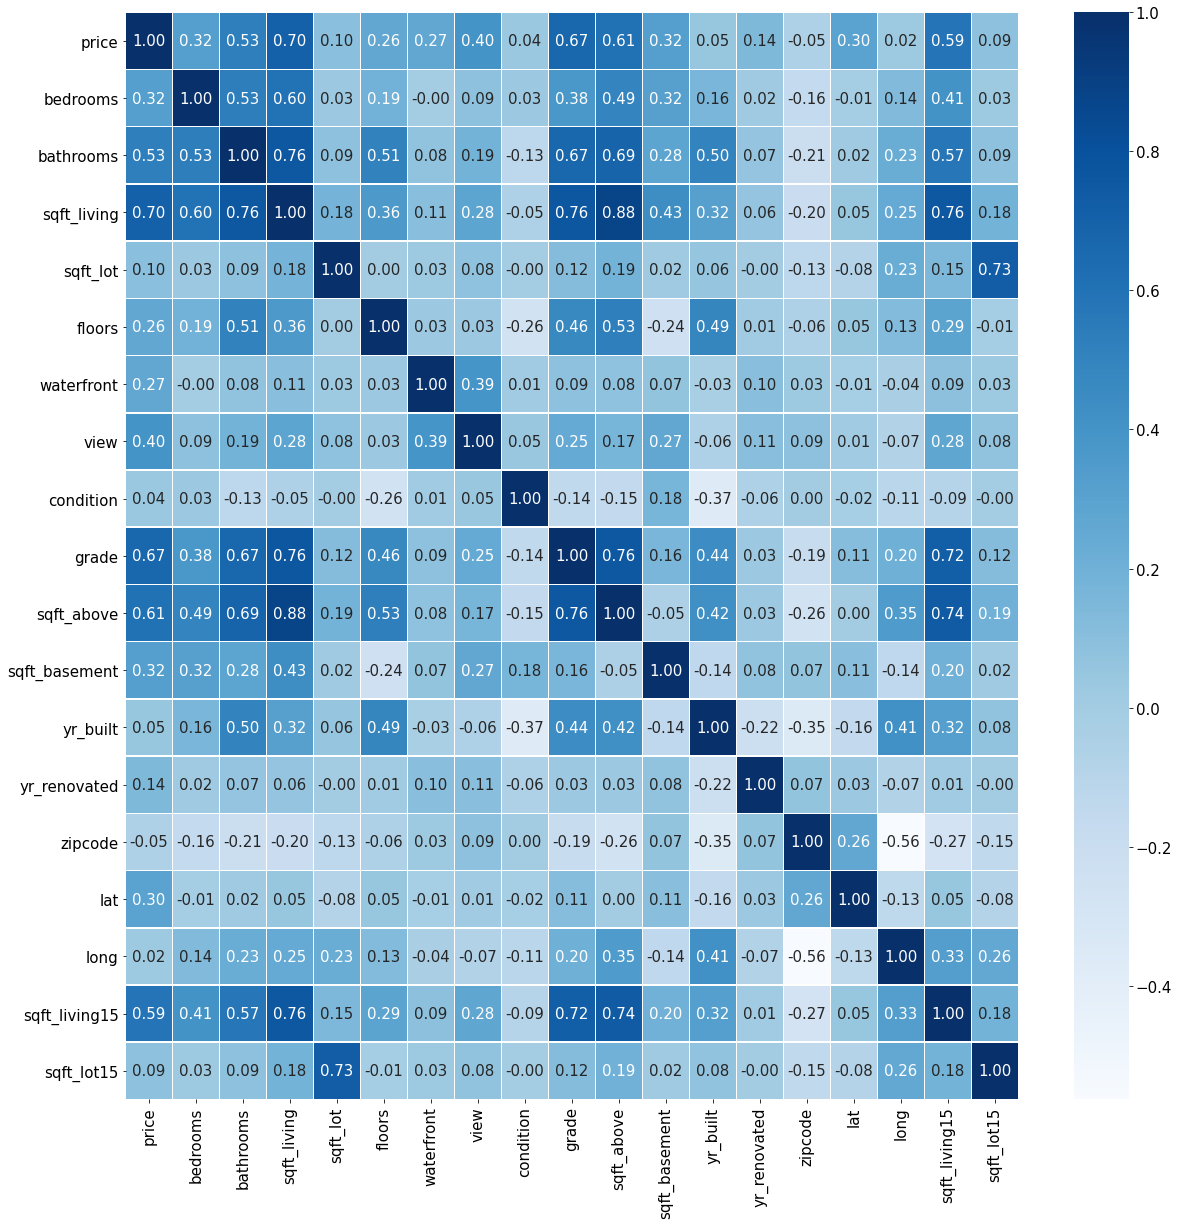

In [5]:
check = train.drop('date', axis=1)
check = train.drop('id', axis=1)

plt.figure(figsize=(20, 20))
sns.heatmap(data=check.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.show()
# bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, grade, sqft_above, sqft_basement, lat, sqft_living15

### 결측치 확인
- ```missingno```사용

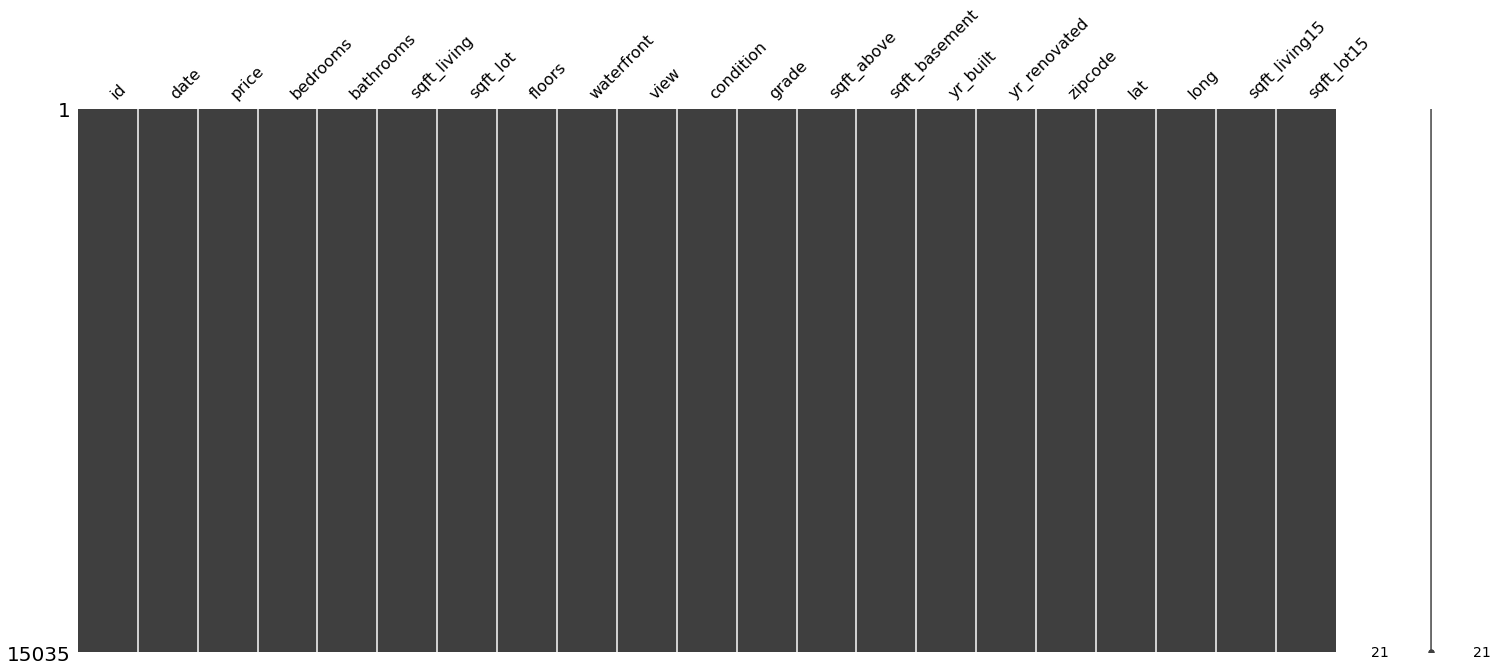

In [6]:
msno.matrix(train)

### 학습 데이터에서 라벨 제거

In [7]:
y = train['price']

train.drop('price', axis=1, inplace=True)
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 학습과 테스트 데이터 일괄 전처리
- 학습 데이터와 테스트 데이터 합치기
- date전처리 => 앞에 6자리만 사용

In [8]:
# 데이터 합치기
# 학습데이터의 길이 저장
train_len = len(train)
data = pd.concat((train, test), axis=0)
print(len(data))

21503


In [9]:
# 날짜 전처리
data['date'] = data['date'].apply(lambda x: x[:6]).astype(int)

In [10]:
# 제출용 id 저장 후 제거
sub_id = data['id'][train_len:]
data.drop('id', axis=1, inplace=True)

In [11]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터 분포 확인
- ```bedrooms```, ```sqft_living```, ```sqft_above```, ```saft_lot```, ```sqft_basemodel``` 변수가 한쪽으로 치우침
- 치우친 데이터에 log를 사용해서 전처리
    - 학습 데이터 + 테스트 데이터
    - label값(y)

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


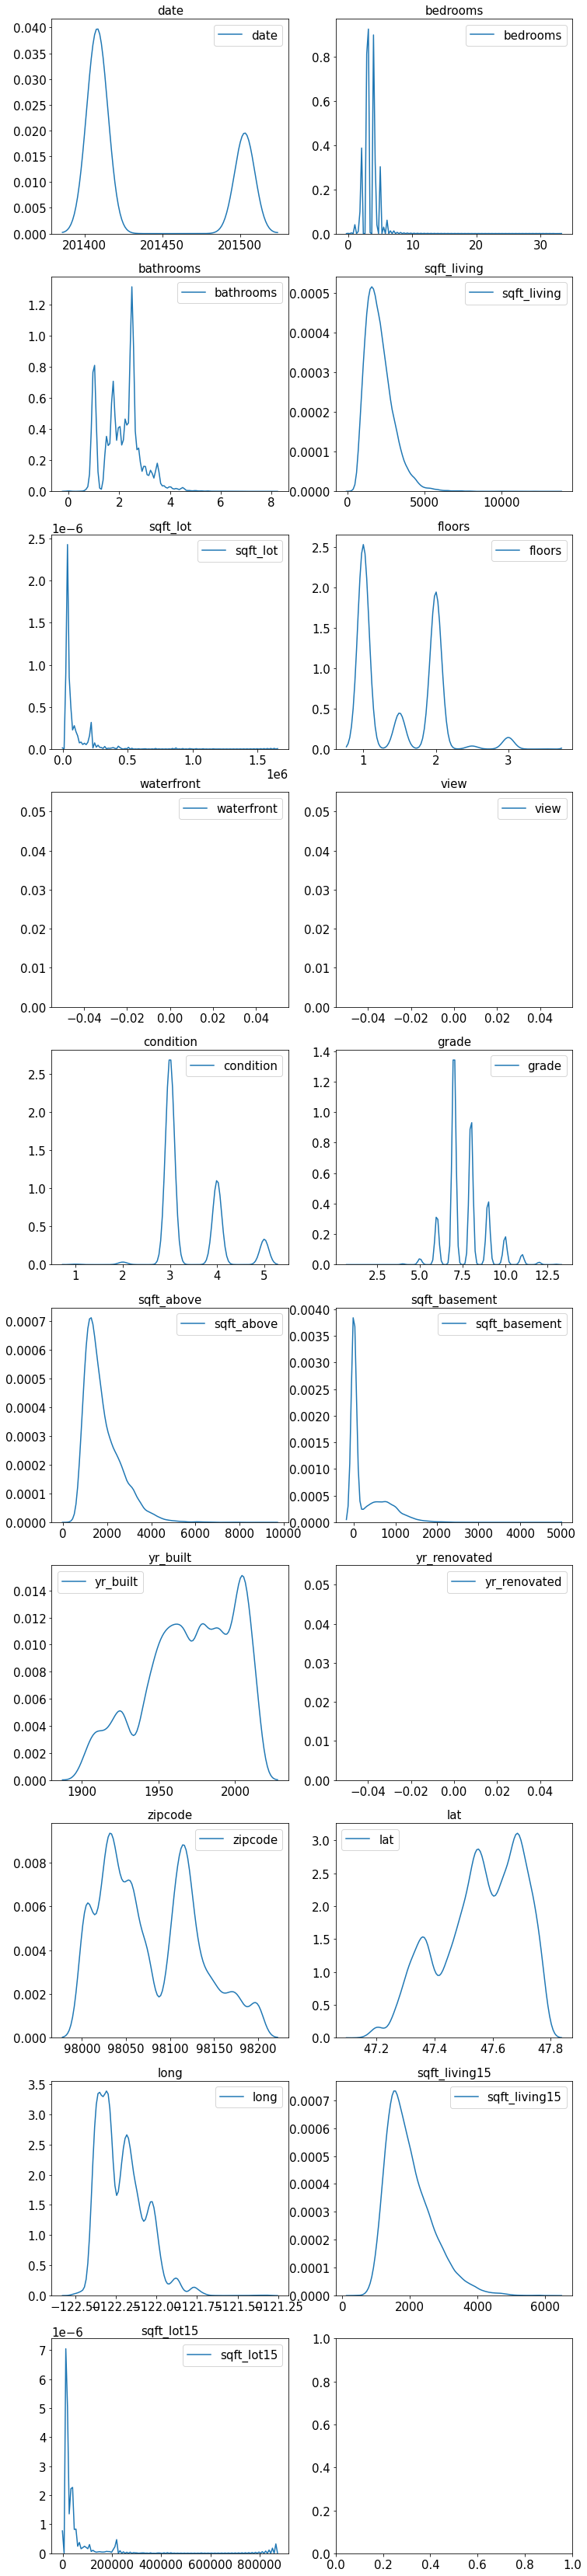

In [12]:
### id 변수를 제외하고 분포를 확인

fig, ax = plt.subplots(10, 2, figsize=(12, 60))

count = 0
columns = data.columns

for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

In [13]:
# 치우친 값들에 대해서 log 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

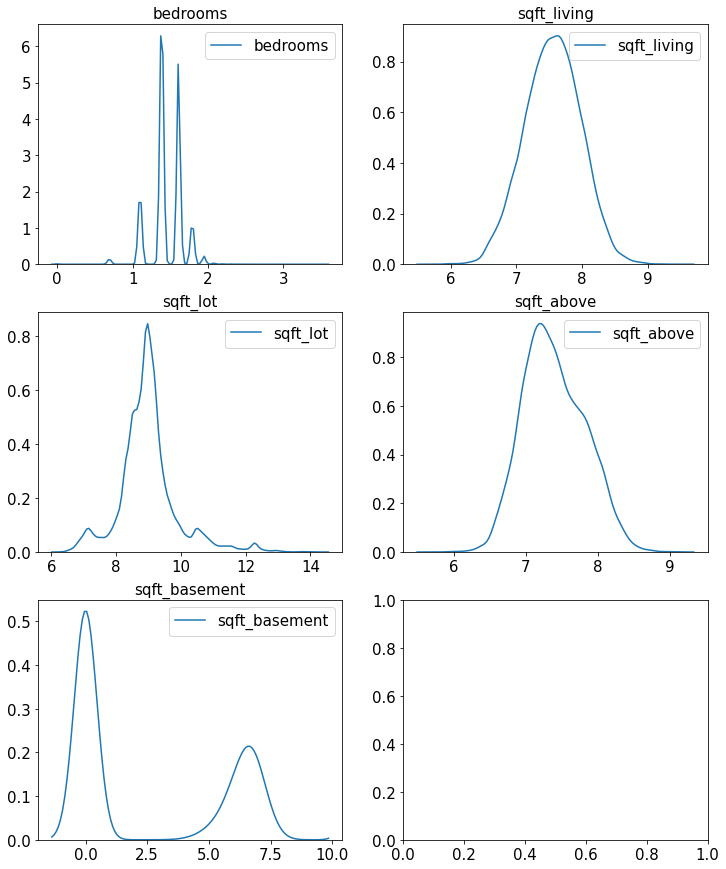

In [14]:
# 로그 변환한 값의 분포 확인
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

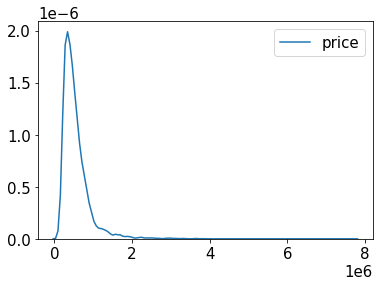

In [15]:
# 라벨값의 분포 확인
sns.kdeplot(y)
plt.show()

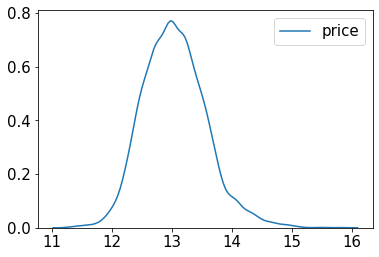

In [16]:
# 라벨값 로그 변환
# 이후에 다시 복원시켜줘야함
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

### 전처리 완료, 학습과 테스트 데이터셋으로 다시 분할

In [17]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


## custom 학습 데이터 만들어 보기
- 상관계수를 기준으로 가격과 상관계수가 높은 feature들만 선택

In [18]:
tmp_lst = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15']

In [19]:
cust_train = pd.DataFrame()
for feature in tmp_lst:
    cust_train[feature] = train[feature]

cust_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,7,7.074117,0.000000,0,47.5112,1340
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,6,6.647688,0.000000,0,47.7379,2720
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,8,7.427144,0.000000,0,47.6168,1800
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,7,7.447751,0.000000,0,47.3097,2238
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,7,6.966967,0.000000,0,47.4095,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,1.609438,2.50,7.832411,8.703507,2.0,0,0,9,7.832411,0.000000,0,47.5137,2520
15031,1.609438,3.50,8.163656,8.881975,2.0,0,0,9,7.863651,6.814543,0,47.5537,2050
15032,1.386294,2.50,7.333676,7.031741,3.0,0,0,8,7.333676,0.000000,0,47.6993,1530
15033,1.609438,2.50,7.745436,8.668024,2.0,0,0,8,7.745436,0.000000,0,47.5107,1830


## 모델 설계

### 함수 정의
- ```rmse```
    - mse를 통해서 rmse 구하기
- ```get_score```
    - 학습 전, rmse score확인
- ```my_GradientSearch```
    - 모델별 파라미터를 찾는 Grid search 수행
- ```get_cv_score```
    - cross validation score확인

In [20]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [21]:
def get_scores(models, train, y):
    df = {}
    
    for model in models :
    
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE',ascending=False)
        
    return score_df

In [22]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [23]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                                  kf=kfold))

### 모델링
- 4가지를 활용
    1. GradientBoosting
    2. XGBoosting
    3. LightGBM
    4. RandomForest
- ```random_state=2020``` 고정
- 모델을 사용하기 전에 간단하게 RMSE 스코어를 확인
    - 모든 데이터를 사용할지, 위에서 만든 custom 학습 데이터를 사용할지
    - 결과는 custom 학습 데이터가 점수가 더 안좋게 나왔다.
        - **유용한 feature를 찾는데 상관계수만 사용하는 것은 좋지 않다.**
- 기존의 학습 데이터를 그대로 이용 => 최적의 모델 하이퍼 파라미터를 찾도록 방향을 잡았다.

In [24]:
# 4가지 모델 생성
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [25]:
get_scores(models, cust_train, y)

,RMSE
GradientBoostingRegressor,160361.980376
RandomForestRegressor,156092.151533
LGBMRegressor,150759.568607
XGBRegressor,149451.203818


In [26]:
sc = get_scores(models, train, y)

In [27]:
sc.sort_values("RMSE", ascending=True)

,RMSE
XGBRegressor,110319.270214
LGBMRegressor,111906.947718
RandomForestRegressor,125325.083751
GradientBoostingRegressor,128360.173766


## Grid Search
- 8월 20일 ~ 8월 24일 수행
    - XGBoost는 정말 느립니다
- 4가지 모델별로 최적의 파라미터를 찾기
- 결과물 중에서 상위 score만 출력 후 파라미터 확인

### LGBM
```python
model = lgb.LGBMRegressor(max_depth=9, n_estimators=169, learning_rate=0.1, num_leaves=43, random_state=random_state)
```
- 0.162082

In [28]:
lgb_param_grid ={
    'n_estimators':[165,166,167,168,169, 170, 171],
    'max_depth':[8,9,10,20],
    'learning_rate' : [0.01, 0.1],
    'num_leaves' : [42,43,44],
    'boostingtype' : ['gbdt', 'rf']
}

In [29]:
lgb_model = lgb.LGBMRegressor(random_state=random_state)

In [30]:
result = my_GridSearch(lgb_model, train, y, lgb_param_grid)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  1.8min finished


In [31]:
result.sort_values('RMSLE', ascending=True).head(15)

,boostingtype,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
118,gbdt,0.1,9,169,43,-0.026271,0.162082
286,rf,0.1,9,169,43,-0.026271,0.162082
115,gbdt,0.1,9,168,43,-0.026271,0.162084
283,rf,0.1,9,168,43,-0.026271,0.162084
121,gbdt,0.1,9,170,43,-0.026274,0.162091
289,rf,0.1,9,170,43,-0.026274,0.162091
124,gbdt,0.1,9,171,43,-0.026275,0.162096
292,rf,0.1,9,171,43,-0.026275,0.162096
280,rf,0.1,9,167,43,-0.026278,0.162105
112,gbdt,0.1,9,167,43,-0.026278,0.162105


---

### XGBoost
- estimator의 수가 적을 때는 LightGBM이 성능이 더 좋았지만 깊이를 깊게하고 estimator의 수를 늘렸을 때, 성능이 더 좋게 나왔다.
- 매우 느리다. n_estimator의 수를 1000개 이상씩 늘려가고 3가지, 2가지만 사용하더라고 6시간 이상의 시간을 소요
```python
xgboost = xgb.XGBRegressor(max_depth=9, n_estimators=2000, learning_rate=0.01, booster='dart', subsample=0.8, colsample_bytree=0.6, random_state=random_state)
```
- 0.156962
- 다양한 경우의 수를 한 번에 grid search를 수행하면 시간이 매우 오래걸려서 n_estimator가 1500개부터는 한가지씩 스코어를 확인

In [32]:
xgb_param_grid ={
    'n_estimators':[2000],  #1800],
    'max_depth':[9],
    'learning_rate' : [0.01],
    'booster' : ['dart'],
    'colsample_bytree':[0.6],
    'subsample' : [0.8]
}
xgboost = xgb.XGBRegressor(random_state=random_state)

In [33]:
xgb_result = my_GridSearch(xgboost, train, y, xgb_param_grid)
xgb_result.sort_values('RMSLE', ascending=True).head(15)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 68.0min finished


,booster,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
0,dart,0.6,0.01,9,2000,0.8,-0.024637,0.156962


---

### GradientBoostingRegressor
```python
gboost = GradientBoostingRegressor(criterion='mse', learning_rate=0.1, max_depth=7, n_estimators=205, random_state=random_state)
```
- 0.164464


In [34]:
gb_param_grid ={
    'n_estimators':[203,204,205,206,210],
    'max_depth':[6,7],
    'criterion' : ['mse'],
    'learning_rate' : [0.01, 0.1],
}

gboost = GradientBoostingRegressor(random_state=random_state)

In [35]:
gb_result = my_GridSearch(gboost, train, y, gb_param_grid)
gb_result.sort_values('RMSLE', ascending=True).head(15)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


,criterion,learning_rate,max_depth,n_estimators,score,RMSLE
17,mse,0.10,7,205,-0.027048,0.164464
18,mse,0.10,7,206,-0.027052,0.164474
16,mse,0.10,7,204,-0.027053,0.164479
15,mse,0.10,7,203,-0.027059,0.164496
19,mse,0.10,7,210,-0.027059,0.164497
12,mse,0.10,6,205,-0.027103,0.164630
14,mse,0.10,6,210,-0.027110,0.164652
13,mse,0.10,6,206,-0.027111,0.164654
10,mse,0.10,6,203,-0.027116,0.164671
11,mse,0.10,6,204,-0.027120,0.164683


---

### RandomForestRegressor
```python
rdf = RandomForestRegressor(max_depth=22, n_estimators=200,random_state=random_state)
```
- 0.177504

In [36]:
rf_param_grid ={
    'n_estimators':[199, 200],
    'max_depth':[22, 23],
}
rdf = RandomForestRegressor(random_state=random_state)

In [37]:
rf_result = my_GridSearch(rdf, train, y, rf_param_grid)
rf_result.sort_values('RMSLE', ascending=True).head(15)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   20.0s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   32.6s finished


,max_depth,n_estimators,score,RMSLE
1,22,200,-0.031508,0.177504
0,22,199,-0.031510,0.177511
3,23,200,-0.031538,0.177589
2,23,199,-0.031541,0.177599


##  Score확인

In [40]:
gboost = GradientBoostingRegressor(criterion='mse', learning_rate=0.1, max_depth=7, n_estimators=205, random_state=random_state)
xgboost = xgb.XGBRegressor(max_depth=9, n_estimators=2000, learning_rate=0.01, booster='dart', subsample=0.8, colsample_bytree=0.6, random_state=random_state)
lightgbm = lgb.LGBMRegressor(max_depth=9, n_estimators=169, learning_rate=0.1, num_leaves=43, random_state=random_state)
rdf = RandomForestRegressor(max_depth=22, n_estimators=200,random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdf, 'name':'RandomForest'}]

In [41]:
get_cv_score(models)

Model GradientBoosting CV score : 0.9025
Model XGBoost CV score : 0.9113
Model LightGBM CV score : 0.9053
Model RandomForest CV score : 0.8864


## 앙상블 시도

### 함수 정의
- ```AveragingBlending```
    - 여러개의 모델들의 score들을 섞어서 평균을 낸다

In [42]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [43]:
# 기존의 로그변환한 y값을 다시 복원
y_pred = AveragingBlending(models, train, y, test)
y_pred = np.expm1(y_pred)

In [44]:
# 제출 파일 생성
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub

,id,price
0,15035,5.053477e+05
1,15036,4.965831e+05
2,15037,1.366702e+06
3,15038,2.931440e+05
4,15039,3.294593e+05
...,...,...
6463,21498,2.355025e+05
6464,21499,3.852824e+05
6465,21500,4.693124e+05
6466,21501,3.271193e+05


In [45]:
sub.to_csv('submission.csv', index=False)

## 제출물 만들기

### 함수 정의
- ```save_submission```
    - 모델과 데이터를 인자로 학습 후 수치 예측
    - 예측한 값 복원 (log변환 했던 값)
    - 경로에 모델 명과 정확도로 제출물 생성

In [46]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 생성
- 위에서 사용한 다양한 모델들의 결과를 평균내는 방식에서 좋은 점수를 얻지 못함
- ```XGboost```모델을 활용

In [47]:
model = xgb.XGBRegressor(max_depth=9, n_estimators=2000, learning_rate=0.01, booster='dart', subsample=0.8, colsample_bytree=0.6, random_state=random_state)

save_submission(model, train, y, test, 'xgb', rmsle='0.156962')

/home/aiffel0042/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.156962.csv saved!


---

## +. XGBoost모델로 앙상블 시도
- 다른 모델에 비해서 성능이 좋았던 XBGoost모델 3가지를 활용
- 성능순서대로 0.6, 0.3, 0.1의 비율로 새로운 제출물 생성

In [48]:
# 라이브러리 import
import os
from glob import glob
import pandas as pd

In [49]:
os.listdir('data')

['submission_xgb_RMSLE_0.157264.csv',
 'submission_lgbm_RMSLE_0.162082.csv',
 'submission_lgbm_RMSLE_0.162.csv',
 'submission_xgb_RMSLE_0.157859.csv',
 'test.csv',
 'submission_lgbm_RMSLE_0.162518.csv',
 'train.csv',
 'submission_lgbm_RMSLE_0.164399.csv',
 'submission_xgb_RMSLE_0.157145.csv',
 'sample_submission.csv',
 'submission.csv',
 'submission_xgb_RMSLE_0.156962.csv',
 'submission_lgbm_RMSLE_0.0168.csv']

In [50]:
sub_lists = glob('data/submission_xgb*')
sub_lists

['data/submission_xgb_RMSLE_0.157264.csv',
 'data/submission_xgb_RMSLE_0.157859.csv',
 'data/submission_xgb_RMSLE_0.157145.csv',
 'data/submission_xgb_RMSLE_0.156962.csv']

In [53]:
ratio = [0.3, 0.1, 0.3, 0.4]

In [54]:
result = pd.DataFrame()
df_1 = pd.read_csv(sub_lists[0])
result['id'] = df_1['id']


for i in range(len(sub_lists)) :
    df=pd.read_csv(sub_lists[i])
    if i == 0 : 
        result['price'] = df['price']*ratio[i]
    else :
        result['price'] += df['price']*ratio[i]
result
result.to_csv('result.csv', index=False)

In [55]:
result

,id,price
0,15035,594017.546
1,15036,513564.478
2,15037,1480398.600
3,15038,328688.829
4,15039,356858.220
...,...,...
6463,21498,249356.441
6464,21499,452426.405
6465,21500,530919.572
6466,21501,357200.652


---

# 정리

- Feature는 많이 건드리지 않고 거의 그대로 사용
- 4가지의 모델을 활용
    1. LightGBM
    2. GradientBoost
    3. XGBoost
    4. RandomForest
- 앙상블 시도 => 하지만 score는 낮아져서 제출물에는 사용하지 않음
- 다양한 하이퍼 파라미터를 사용
    - 모델 별로 수십번 돌아가면서 feature에서 모자른 부분을 하이퍼 파라미터 튜닝 시도
    - Grid Search 활용
    - 모델마다 요구하는 파라미터가 다 다르다.
        - ```max_depth```, ```learning_rate```, ```n_estimators```, ```num_leaves```, ```boosting_type``` 외에도 다양하게 존재
        
----
## 개선점
1. **Feature Engineering**
    - 캐글 뿐만 아니라 다양한 Competition에서 결국에는 결과물이 중요하다고는 하지만 꼼꼼한 EDA를 통한 데이터이해, EDA를 바탕으로한 Feature Engineering이 전체 결과물의 아마 반이상을 차지할 것이다.
    - 캐글에 공유되어 있는 고수님들의 코드를 따라치면서 공부를 해보는 방향으로 해본다.  
      
      
2. **앙상블 기법 활용**
    - Feature Engineering이 선행된다면 위에서 처럼 앙상블 기법을 해도 점수가 좀더 좋아지지 않을까 예상해본다.  
      
      
3. **Random Search 활용**
    - 일반적으로 Grid Search를 사용하면 최적의 파라미터를 한 번에 못 찾는다고 한다. 하지만 위에서 실습할 때 Grid Search를 수행하면서 게속 범위를 좁혀 나가면서 그러한 단점을 최소화시키려고 시도하였다.
    - 이러한 부분에서 시간을 많이 소비하게 되었는데 Random Search를 통해서 시간을 단축시킬 수 있는지, 정말로 Grid Search에서는 못찾았던 최적의 하이퍼파라미터를 찾을 수 있는지 확인해야 할 것이다.